# Telecom Churn Prediction

* [Introduction](#Introduction)
* [Dataset exploration](#Dataset-exploration)
* [Baseline models for churn classification](#Baseline-models-for-churn-classification)
* [Explainig models](#Explainig-models)
* [Uplift models](#Uplift-models)
* [Take out](#Take-out)

### Importing libraries

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import pingouin as pg

In [4]:
data = pd.read_csv('data/telecom_churn.csv')

## Introduction

Every company wants to provide best services to their customers. One way to learn how to improve quality of the provide service and satisfie users is to learn why they are leaving the company. Another term for that phenomena is churn rate. In this notebook I will try to understand why certain users are leaving the provider. I'm using kaggle dataset [Customer Churn](https://www.kaggle.com/datasets/barun2104/telecom-churn) for this task. Therefore I will build machine learning models to classify users that are likely to leave. 

If possible I will try to find efficent way to reach out to those users and try to convince them to stay. In other ways I will try to find out what are the most important features that are related to churn. And I will try myself in uplift modelling.

**Research questions**
- What are the most important features that are related to churn?
- Can we build a model that will predict churn?
- Can we learn which feature change to provide better service for customers and have higher retain rate?
- What action should be taken to prevent churn?

## Dataset exploration

### EDA

Dataset consist of 13 variables and 3333 rows. There are 3 types of variables: categorical, numerical and binary. **Churn** is our target vairiable. It is binary variable with values 0 and 1. 0 means that user is still with the company and 1 means that user has left the company.

There are 2 categorical vairables: Contract Renewal, Data Plan.

The rest of data (10 rows) is numerical.

In [5]:
data.head(3)

,Churn,AccountWeeks,ContractRenewal,DataPlan,DataUsage,CustServCalls,DayMins,DayCalls,MonthlyCharge,OverageFee,RoamMins
0,0,128,1,1,2.7,1,265.1,110,89.0,9.87,10.0
1,0,107,1,1,3.7,1,161.6,123,82.0,9.78,13.7
2,0,137,1,0,0.0,0,243.4,114,52.0,6.06,12.2


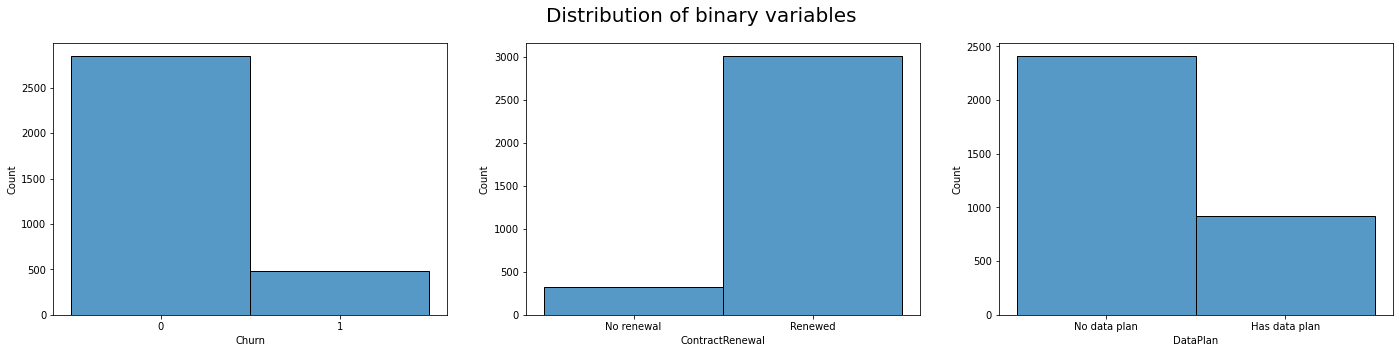

In [6]:
fig, ax = plt.subplots( 1,3, figsize=(24, 5))
plt.suptitle('Distribution of binary variables', fontsize=20)

sns.histplot(data['Churn'],discrete=True,ax=ax[0])
ax[0].set_xticks([0,1]);

sns.histplot(data['ContractRenewal'],discrete=True, ax=ax[1])
ax[1].set_xticks([0,1],['No renewal','Renewed']);

sns.histplot(data['DataPlan'],discrete=True, ax=ax[2])
ax[2].set_xticks([0,1],['No data plan','Has data plan']);

- Dataset is poorly balanced users that churned contribute to 15% of the dataset. Stratification and balancing trainig sets is strongly adiviced.
- Contract renewal means that userhas recently renewed contract with the company. It is not clear what is the time period of the contract.
- 28% of the users besides having regular phone service have alse internet acces via smarphone.

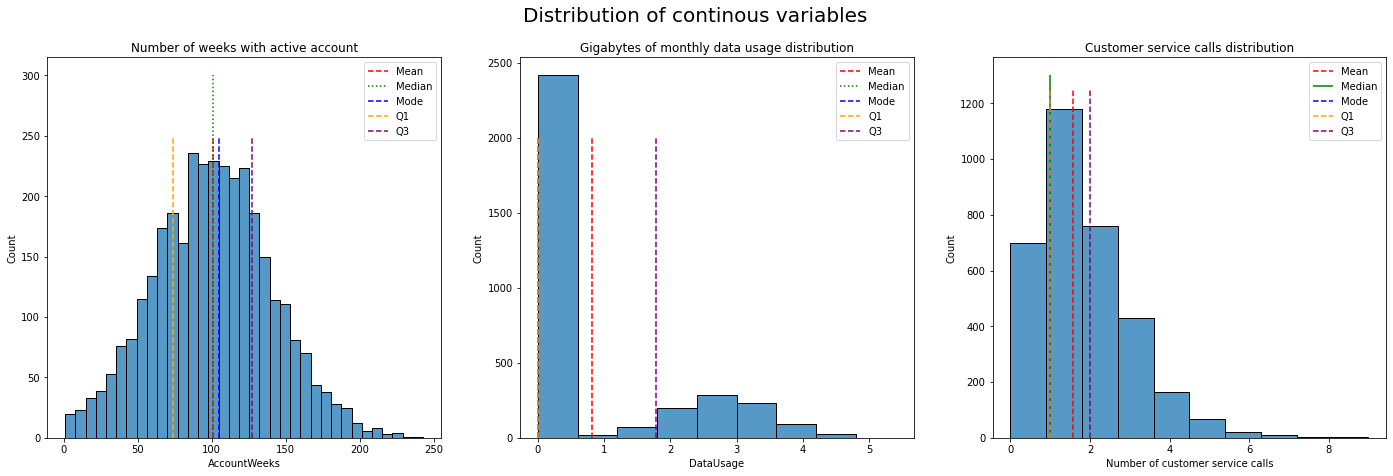

In [7]:
fig, ax = plt.subplots( 1,3, figsize=(24, 7))
plt.suptitle('Distribution of continous variables', fontsize=20)

sns.histplot(data['AccountWeeks'],ax=ax[0])
ax[0].set_title('Number of weeks with active account')
ax[0].vlines(data['AccountWeeks'].mean(),0,250,color='red',label='Mean' , linestyles='dashed')
ax[0].vlines(data['AccountWeeks'].median(),0,300,color='green',label='Median', linestyles='dotted')
ax[0].vlines(data['AccountWeeks'].mode()[0],0,250,color='blue',label='Mode', linestyles='dashed')
ax[0].vlines(data['AccountWeeks'].quantile(0.25),0,250,color='orange',label='Q1', linestyles='dashed')
ax[0].vlines(data['AccountWeeks'].quantile(0.75),0,250,color='purple',label='Q3', linestyles='dashed')
ax[0].legend();


sns.histplot(data['DataUsage'],bins=9,ax=ax[1])
ax[1].set_title('Gigabytes of monthly data usage distribution')
ax[1].vlines(data['DataUsage'].mean(),0,2000,color='red',label='Mean' , linestyles='dashed')
ax[1].vlines(data['DataUsage'].median(),0,2000,color='green',label='Median', linestyles='dotted')
ax[1].vlines(data['DataUsage'].mode()[0],0,2000,color='blue',label='Mode', linestyles='dashed')
ax[1].vlines(data['DataUsage'].quantile(0.25),0,2000,color='orange',label='Q1', linestyles='dashed')
ax[1].vlines(data['DataUsage'].quantile(0.75),0,2000,color='purple',label='Q3', linestyles='dashed')
ax[1].legend();


sns.histplot(data['CustServCalls'],bins=10, ax = ax[2])
ax[2].set_title('Customer service calls distribution')
ax[2].vlines(data['CustServCalls'].mean(),0,1250,color='red',label='Mean' , linestyles='dashed')
ax[2].vlines(data['CustServCalls'].median(),0,1300,color='green',label='Median', linestyles='solid')
ax[2].vlines(data['CustServCalls'].mode()[0],0,1250,color='blue',label='Mode', linestyles='dashed')
ax[2].vlines(data['CustServCalls'].quantile(0.25),0,1250,color='orange',label='Q1', linestyles='dashed')
ax[2].vlines(data['CustServCalls'].quantile(0.75),0,1250,color='purple',label='Q3', linestyles='dashed')
ax[2].set_xlabel('Number of customer service calls')
ax[2].legend();

- Average of active contract is 101 weeks (around 23 months). Most contracts lifespan is between 74 weeks and 127 weeks (around 17 months and 29 months).
- Since most users doesn't have data plan data usage variable have most it's variable around 0.
- Customer service calls is highly skewed. Most users have 1 or 2 customer service calls. There are some users with more than 4 calls. It's plausible that those users are more likely to churn.

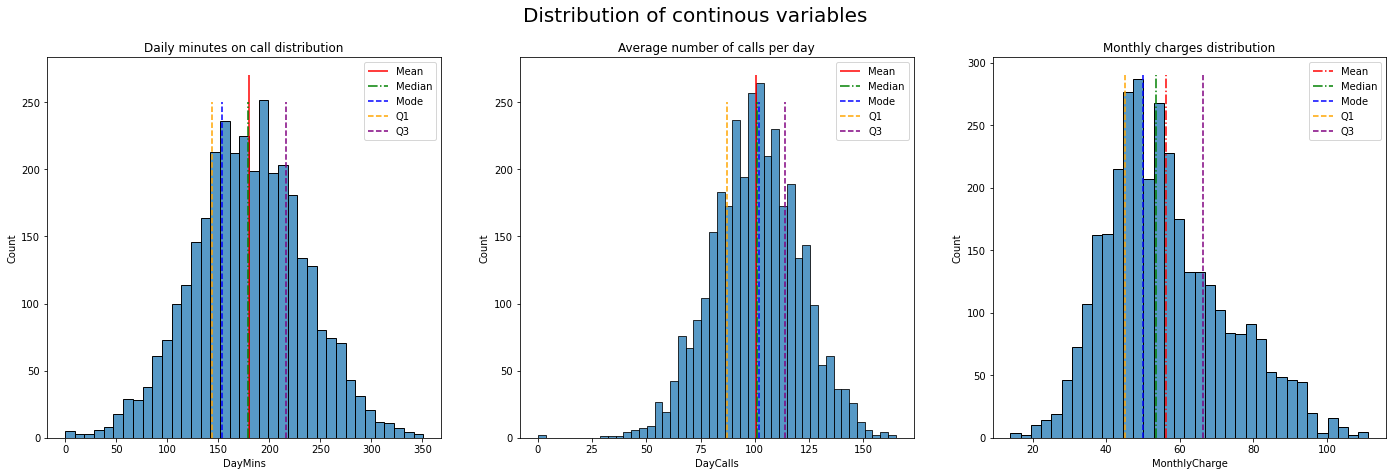

In [8]:
fig, ax = plt.subplots( 1,3, figsize=(24, 7))
plt.suptitle('Distribution of continous variables', fontsize=20)

sns.histplot(data['DayMins'], ax=ax[0])
ax[0].set_title('Daily minutes on call distribution')
ax[0].vlines(data['DayMins'].mean(),0,270,color='red',label='Mean' , linestyles='solid')
ax[0].vlines(data['DayMins'].median(),0,250,color='green',label='Median', linestyles='dashdot')
ax[0].vlines(data['DayMins'].mode()[0],0,250,color='blue',label='Mode', linestyles='dashed')
ax[0].vlines(data['DayMins'].quantile(0.25),0,250,color='orange',label='Q1', linestyles='dashed')
ax[0].vlines(data['DayMins'].quantile(0.75),0,250,color='purple',label='Q3', linestyles='dashed')
ax[0].legend();

sns.histplot(data['DayCalls'], ax=ax[1]);
ax[1].set_title('Average number of calls per day')
ax[1].vlines(data['DayCalls'].mean(),0,270,color='red',label='Mean' , linestyles='solid')
ax[1].vlines(data['DayCalls'].median(),0,250,color='green',label='Median', linestyles='dashdot')
ax[1].vlines(data['DayCalls'].mode()[0],0,250,color='blue',label='Mode', linestyles='dashed')
ax[1].vlines(data['DayCalls'].quantile(0.25),0,250,color='orange',label='Q1', linestyles='dashed')
ax[1].vlines(data['DayCalls'].quantile(0.75),0,250,color='purple',label='Q3', linestyles='dashed')
ax[1].legend();

sns.histplot(data['MonthlyCharge'], ax=ax[2]);
ax[2].set_title('Monthly charges distribution')
ax[2].vlines(data['MonthlyCharge'].mean(),0,290,color='red',label='Mean' , linestyles='dashdot')
ax[2].vlines(data['MonthlyCharge'].median(),0,290,color='green',label='Median', linestyles='dashdot')
ax[2].vlines(data['MonthlyCharge'].mode()[0],0,290,color='blue',label='Mode', linestyles='dashed')
ax[2].vlines(data['MonthlyCharge'].quantile(0.25),0,290,color='orange',label='Q1', linestyles='dashed')
ax[2].vlines(data['MonthlyCharge'].quantile(0.75),0,290,color='purple',label='Q3', linestyles='dashed')
ax[2].legend();

- 75 percent of users spend at least 2 hours per day on the phone.
- On average users calls 56 times per day. It's seems rather high number. I wonder if it's possible to have so many calls per day.
- On average customers are paying 56 dollars per month. Most customers are paying between 45 and 65 dollars per month.

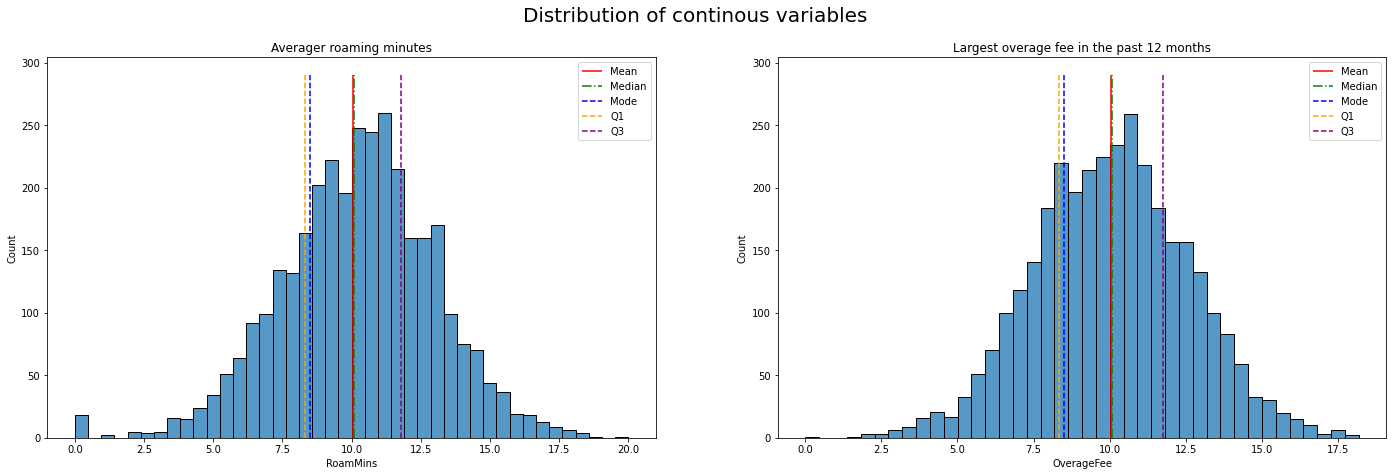

In [9]:
fig, ax = plt.subplots( 1,2, figsize=(24, 7))
plt.suptitle('Distribution of continous variables', fontsize=20)

sns.histplot(data['RoamMins'], ax = ax[0]);
ax[0].set_title('Averager roaming minutes')
ax[0].vlines(data['OverageFee'].mean(),0,290,color='red',label='Mean' , linestyles='solid')
ax[0].vlines(data['OverageFee'].median(),0,290,color='green',label='Median', linestyles='dashdot')
ax[0].vlines(data['OverageFee'].mode()[0],0,290,color='blue',label='Mode', linestyles='dashed')
ax[0].vlines(data['OverageFee'].quantile(0.25),0,290,color='orange',label='Q1', linestyles='dashed')
ax[0].vlines(data['OverageFee'].quantile(0.75),0,290,color='purple',label='Q3', linestyles='dashed')
ax[0].legend();


sns.histplot(data['OverageFee'], ax = ax[1]);
ax[1].set_title('Largest overage fee in the past 12 months')
ax[1].vlines(data['OverageFee'].mean(),0,290,color='red',label='Mean' , linestyles='solid')
ax[1].vlines(data['OverageFee'].median(),0,290,color='green',label='Median', linestyles='dashdot')
ax[1].vlines(data['OverageFee'].mode()[0],0,290,color='blue',label='Mode', linestyles='dashed')
ax[1].vlines(data['OverageFee'].quantile(0.25),0,290,color='orange',label='Q1', linestyles='dashed')
ax[1].vlines(data['OverageFee'].quantile(0.75),0,290,color='purple',label='Q3', linestyles='dashed')
ax[1].legend();

- Users on average spend 10 minutes on roaming.
- 

### Relationships

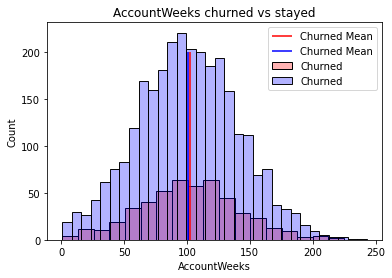

In [10]:
plt.title('AccountWeeks churned vs stayed')
sns.histplot(data[data.Churn == 1]['AccountWeeks'], label='Churned', color='red', alpha = 0.3)
plt.vlines(data[data.Churn == 1]['AccountWeeks'].mean(), 0, 200, color='red', label='Churned Mean')

sns.histplot(data[data.Churn == 0]['AccountWeeks'], label='Churned', color='blue',alpha = 0.3)
plt.vlines(data[data.Churn == 0]['AccountWeeks'].mean(), 0, 200, color='blue', label='Churned Mean')
plt.legend()

#### Customer service calls and  churn

In [11]:
three_calls = data[data['CustServCalls'] > 2] # 3,4,5, 6,7,8,9
four_calls = data[data['CustServCalls'] > 3] # 4,5, 6,7,8,9
five_calls = data[data['CustServCalls'] > 4] # 5, 6,7,8,9
six_calls = data[data['CustServCalls'] > 5] #  6,7,8,9
data['CustServCalls'].value_counts()

1    1181
2     759
0     697
3     429
4     166
5      66
6      22
7       9
9       2
8       2
Name: CustServCalls, dtype: int64

In [12]:
print(f"Churn rate in three or more calls group: {round(len(three_calls[three_calls['Churn'] == 1]) / len(three_calls),2)}, Churn rate in four or more calls group:  {round(len(four_calls[four_calls['Churn'] == 1]) / len(four_calls),2)}.")

Churn rate in three or more calls group: 0.26, Churn rate in four or more calls group:  0.52.


In [13]:
print(f"Churn rate in five or more calls group: {round(len(five_calls[five_calls['Churn'] == 1]) / len(five_calls),2)}, Churn rate in six or more calls group: {round(len(six_calls[six_calls['Churn'] == 1]) / len(six_calls),2)}")

Churn rate in five or more calls group: 0.61, Churn rate in six or more calls group: 0.63


## Baseline models for churn classification

I have started with data preparation. I used scikit learn Columntransformer to standard scale contionous variable sand one hot encode categorical variables. This transformation I used for all of the models with expetion to t-sne modelling but more about that later. 

### Baseline models

![image](charts/baseline_models_accuracy.png)

Most models had high accuracy score. The best models were scikit learn Multilayerperceptron, Random Forest and XGBoost. Althought other metrics were not so good. Quadratic Discriminant Analysis had the worst accuracy

![image](charts/baseline_precision.png)

Precision is the most important metric for my model because we want to minimize false positives. So we don't spend resources on users that are not likely to churn. The best model was Linear Supprt Vectoer Machines and the worst again QDA.

![image](charts/baseline_recall.png)

Surprisingly the best model was QDA. It had the best recall score. The worst model was Naive Bayes.

![image](charts/baseline_f1score.png)

F1 score is the harmonic mean of precision and recall. The best model was Neural network, Random Forest adn XGBoost. The worst model was Naive Bayes.

![image](charts/baseline_roc.png)

Naive bayes scored the lowest ROC AUC score. The best model was Neural network, Random Forest and XGBoost.

## Dimensionality reduction

### PCA

Performing principal component analysis on the data proved that 6 components explain almost 100% of the variance. Results made me think how dimensionality reduction influece models.

In [20]:
from sklearn.decomposition import PCA

pca =PCA(n_components=6, random_state=42)
pca.fit(data)

pca.explained_variance_ratio_

array([0.58352212, 0.30258468, 0.07667953, 0.03427105, 0.00147165,
       0.00109944])

In [21]:
np.sum([0.58352212, 0.30258468, 0.07667953, 0.03427105, 0.00147165,
       0.00109944]) # explained variance ration summed up

0.9996284700000001

### Tsne models

Later on I decide to use t-sne on the data and see how much inforamtion i lose and if i can visualize multidimensionality of the data. I used 2 components and perplexity equal to 30. 

e:\anaconda\envs\data_science\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
e:\anaconda\envs\data_science\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3333 samples in 0.007s...
[t-SNE] Computed neighbors for 3333 samples in 0.102s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3333
[t-SNE] Computed conditional probabilities for sample 2000 / 3333
[t-SNE] Computed conditional probabilities for sample 3000 / 3333
[t-SNE] Computed conditional probabilities for sample 3333 / 3333
[t-SNE] Mean sigma: 11.239228
[t-SNE] Computed conditional probabilities in 0.130s
[t-SNE] Iteration 50: error = 80.5675659, gradient norm = 0.0533878 (50 iterations in 1.272s)
[t-SNE] Iteration 100: error = 74.2674637, gradient norm = 0.0005467 (50 iterations in 0.920s)
[t-SNE] Iteration 150: error = 74.2251053, gradient norm = 0.0001784 (50 iterations in 0.930s)
[t-SNE] Iteration 200: error = 74.2248383, gradient norm = 0.0001571 (50 iterations in 0.869s)
[t-SNE] Iteration 250: error = 74.2247925, gradient norm = 0.0001109 (50 iterations in 0.833s)
[t-SNE] KL divergence after 250 iterat

<AxesSubplot: xlabel='0', ylabel='1'>

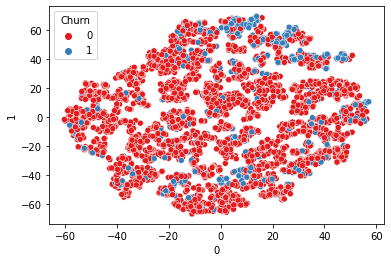

In [22]:
from sklearn.manifold import TSNE
X , y = data.drop('Churn', axis=1), data['Churn']
c_30 = TSNE(n_components=2, perplexity=30, verbose=2).fit_transform(X);

tsne_vis = pd.concat([pd.DataFrame(c_30), y], axis=1)

sns.scatterplot(x=tsne_vis.iloc[:,0],y=tsne_vis.iloc[:,1], hue=tsne_vis.Churn, palette='Set1')

Visualization of the data after using various parameters of perplexity wheren't very helpful. Above you can see the visualization of the data with perplexity equal to 30. It's hard to see any valid churn clusters. However I decided to use this data for modelling.

![image](charts/base_tsne_accuracy.png)

On the first glance it seems that models perform just a bit worse than on the original data. However it's not the case. Models perform much worse on the t-sne data. On the next three metrics you can see precision, recall and f1 score. All of the models perform much worse on the t-sne data.

![image](charts/baseline_tsne_precision.png)

![image](charts/baseline_tsne_recall.png)

![image](charts/baseline_tsne_f1.png)

T-sne happend to be dead end. I will not use it for further modelling in this project.

## Explainig models

### XGBoost feature importance

![image](charts/xgboost_feature_importance.png)

### SHAP values

![image](charts/xgb_base_shap.png)

I have used inbuilt Xgboost features importance and Shap values to understand which features are most important for the model. I have used Xgboost model because it was the best overall model in terms of only metrics.
- Feature imporatnce:
    - Information if the customer recently renewed contract is the most important feature. This feature feels a bit of data leakage. Because there is very slim chance that customer will cancel the agreement if couple weeks before he or she signed the contract.
    - Second most imporatant variable is Account weeks. Regural customers are less likely to churn.
    - Users that have called customer service multiple times are more likely to churn.  
    - Monthly bilings are fourth most imporatant variable.
- SHAP values:
    - Interestingly SHAP values are showing different perspective on the model.
    - Overage fee is the variable that is the most impactful for the model. 
    - Daily time spent talking is the second one.
    - Monthly charges is the third one.

### Best classification models

#### Voting classifier

#### Pycaret Random forest

## Uplift models

## Take out